## Set up requirements

In [1]:
%pip install catboost lightgbm torch imblearn xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset, WeightedRandomSampler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, roc_curve, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans, HDBSCAN
from sklearn.neighbors import LocalOutlierFactor
from numpy import loadtxt
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load data

In [10]:
data1=np.load("first_batch_with_labels_likes.npz")
data2=np.load("second_batch_with_labels_likes.npz")
data3=np.load("third_batch_with_labels_likes.npz")
data4=np.load("fourth_batch_with_labels_likes.npz")

XX1=pd.DataFrame(data1["X"])
yy1=pd.DataFrame(data1["y"])
XX2=pd.DataFrame(data2["X"])
yy2=pd.DataFrame(data2["y"])
XX3=pd.DataFrame(data3["X"])
yy3=pd.DataFrame(data3["y"])
XX4=pd.DataFrame(data4["X"])
yy4=pd.DataFrame(data4["y"])

dfX = pd.concat([XX1, XX2, XX3, XX4])
dfy = pd.concat([yy1, yy2, yy3, yy4])

dfX.rename(columns={0:"user",1:"item",2:"rating"},inplace=True)
dfy.rename(columns={0:"user",1:"label"},inplace=True)

dfX = dfX.pivot(index = 'user',columns = 'item',values = 'rating').reset_index(drop=True)
dfy = dfy['label']

## One hot encoding and Engineer features

In [11]:
dfX.columns = dfX.columns.astype(str) # str columns needed
dfX_unsup = dfX

# One hot encoding
oheX = OneHotEncoder()
dfX_lgbm_onehot = pd.DataFrame(oheX.fit_transform(dfX_lgbm.fillna(-2).astype(int) + 2).toarray())

dfX_nn = dfX.fillna(-2).astype(int) + 2
dfX_nn_onehot = pd.DataFrame(oheX.fit_transform(dfX_nn).toarray())

# Engineering features
dfX['VAR'] = dfX.var(axis=1)
dfX['sum_-1'] = (dfX.iloc[:, 0:999] == -1).sum(axis=1)
dfX['sum_0'] = (dfX.iloc[:, 0:999] == 0).sum(axis=1)
dfX['sum_1'] = (dfX.iloc[:, 0:999] == 1).sum(axis=1)
dfX_rf = dfX.fillna(-2).astype(int) + 2
dfX_unsup = dfX_rf
dfX_xgb = dfX
dfX_lgbm = dfX
dfX_cat = dfX

# one hot dataframe needs to copy the sum columns separately
dfX_lgbm_onehot[['VAR', 'sum_-1', 'sum_0', 'sum_1']] = dfX[['VAR', 'sum_-1', 'sum_0', 'sum_1']].copy()
dfX_nn_onehot[['VAR', 'sum_-1', 'sum_0', 'sum_1']] = dfX[['VAR', 'sum_-1', 'sum_0', 'sum_1']].copy()

dfX_lgbm_onehot.columns = dfX_lgbm_onehot.columns.astype(str)
dfX_nn_onehot.columns = dfX_nn_onehot.columns.astype(str)

## Train and test models

In [6]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=31)

### Unsupervised/semi-supervised models

In [12]:
# Unsupervised/semi-supervised : with stratified K-fold
proba_ocsvm = []
AUC_ocsvm = []

for i, (train_index, test_index) in enumerate(kf.split(dfX_unsup, dfy)):
    X_train, y_train = dfX_unsup.iloc[train_index], dfy.iloc[train_index]
    X_test, y_test = dfX_unsup.iloc[test_index], dfy.iloc[test_index]

    ocsvm = OneClassSVM()
    ocsvm.fit(X_train)
    ocsvm_preds = ocsvm.score_samples(X_test)
    AUC_ocsvm.append(roc_auc_score(y_test, ocsvm_preds))

    
hdb = HDBSCAN(min_cluster_size=4, min_samples=4)
hdb.fit(dfX_unsup)
hdb_preds = hdb.probabilities_
AUC_hdb = roc_auc_score(dfy, hdb_preds)

km = KMeans(n_clusters=2)
km_preds = km.fit_transform(dfX_unsup)
km_preds = [-x for x in km_preds]
AUC_km = roc_auc_score(dfy, [i[0] for i in km_preds])

lof = LocalOutlierFactor()
lof_preds = -lof.fit_predict(dfX_unsup)
AUC_lof = roc_auc_score(dfy, lof_preds)

print("AUCs")
print(f"K means: {AUC_km}, HDBSCAN: {AUC_hdb}, One-class SVM: {sum(AUC_ocsvm)/len(AUC_ocsvm)}, LOF: {AUC_lof}")

AUCs
K means: 0.5902454545454546, HDBSCAN: 0.5150957954545454, One-class SVM: 0.5790965909090909, LOF: 0.4989545454545455


### Supervised models

The basic procedures are illustrated as follows:

1. First do stratified 5-Fold splits on the whole dataset to generate training set and test set. 
2. And for each training set and each parameter space, use 5-Fold stratified train-validation split to calculate the average AUC and optimize it with gp_minimize function.
3. Use the optimized parameters to train on the this training set and see how well it performs on the test set. 
4. Finally, we could get 5 AUC corresponding to each train-test split and average them to see the robust performance of the algorithm.


#### Random Forest

In [14]:
# Initialize result columns
proba_rf = []
AUC_rf = []
# Create a random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create parameter space
param_space = [Integer(5, 1000, name='max_depth'),
               Integer(200, 10000, name='n_estimators'),
               Categorical(['sqrt', 'log2'], name='max_features'),
               Categorical(['gini', 'entropy', 'log_loss'], name='criterion'),
               Real(0.05, 1.0, name='min_samples_split'),
        ]

# Define optimization functions: 1 - average AUC here
@use_named_args(param_space)
def objective(**params):
    rf.set_params(**params)
    # minimize 1 - AUC
    return 1 - np.mean(cross_val_score(rf, X_train, y_train, cv=kf, n_jobs=-1,
                                    scoring="roc_auc"))


for i, (train_index, test_index) in enumerate(kf.split(dfX_rf, dfy)):
    X_train, y_train = dfX_rf.iloc[train_index], dfy.iloc[train_index]
    X_test, y_test = dfX_rf.iloc[test_index], dfy.iloc[test_index]
    
    opt = gp_minimize(objective, 
                      param_space, 
                      n_calls=15, 
                      n_initial_points=5, 
                      random_state=0)
    best_values = opt.x
    optimal_values = dict(zip([param.name for param in param_space], best_values))

    print('optimal_parameters: {}'.format(optimal_values))
    print('updating model with optimal values')
    rf.set_params(**optimal_values)
    rf.fit(X_train, y_train)
    proba = rf.predict_proba(X_test)
    proba_rf.append(proba[:, 1])
    AUC = roc_auc_score(y_test, proba[:,1])
    AUC_rf.append(AUC)
    print("AUC:", round(AUC, 5))

C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


optimal_parameters: {'max_depth': 1000, 'n_estimators': 10000, 'max_features': 'log2', 'criterion': 'gini', 'min_samples_split': 0.05}
updating model with optimal values
AUC: 0.86836
optimal_parameters: {'max_depth': 866, 'n_estimators': 5477, 'max_features': 'sqrt', 'criterion': 'gini', 'min_samples_split': 0.05}
updating model with optimal values
AUC: 0.90145
optimal_parameters: {'max_depth': 1000, 'n_estimators': 10000, 'max_features': 'sqrt', 'criterion': 'gini', 'min_samples_split': 0.05}
updating model with optimal values
AUC: 0.89478
optimal_parameters: {'max_depth': 1000, 'n_estimators': 10000, 'max_features': 'sqrt', 'criterion': 'gini', 'min_samples_split': 0.05}
updating model with optimal values
AUC: 0.89026
optimal_parameters: {'max_depth': 1000, 'n_estimators': 10000, 'max_features': 'sqrt', 'criterion': 'log_loss', 'min_samples_split': 0.05}
updating model with optimal values
AUC: 0.87219


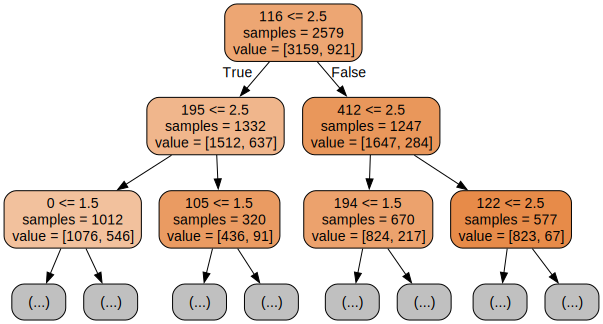

In [15]:
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
from subprocess import call
import graphviz
# Export the first three decision trees from the forest

for i in range(1):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               rounded=True,
                               precision=2,
                               max_depth=2, 
                               impurity=False, 
                               proportion=False,
                              )
    graph = graphviz.Source(dot_data)
    display(graph)
#     filename = graph.render(filename='img/graph')
#     pylab.savefig('graph.png')

#### XGBoost

In [16]:
# Initialize result columns
proba_xgb = []
AUC_xgb = []
XGB = XGBClassifier(tree_method='approx', objective='binary:logistic')
# approx tree method: An approximation tree method. 
# It runs sketching before building each tree using all the rows (rows belonging to the root).

param_space = [Real(0.01, 0.3, name='eta'),
               Real(0.01, 1, name='min_child_weight'),
               Integer(500, 1000, name='n_estimators'),
               Integer(3, 12, name='max_depth'),
               Real(0.5, 1, name='subsample'),
               Integer(50, 400, name='max_bin'),
               Real(0.5, 1, name='colsample_bytree'),
               Real(1, 2, name='lambda'),
               Real(0, 0.3, name='gamma'),
               Real(3, 4, name='scale_pos_weight') # useful for imbalanced classes, e.g., sum(negative) / sum(positive)
                ]
@use_named_args(param_space)

# Define optimization functions
def objective(**params):
    XGB.set_params(**params)
    # minimize 1 - AUC
    return 1 - np.mean(cross_val_score(XGB, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="roc_auc"))

for i, (train_index, test_index) in enumerate(kf.split(dfX_xgb, dfy)):
    X_train, y_train = dfX_xgb.iloc[train_index], dfy.iloc[train_index]
    X_test, y_test = dfX_xgb.iloc[test_index], dfy.iloc[test_index]

    opt = gp_minimize(objective, 
                      param_space, 
                      n_calls=10, 
                      n_initial_points=3, 
                      random_state=0)
    best_values = opt.x
    optimal_values = dict(zip([param.name for param in param_space], best_values))

    print('optimal_parameters: {}'.format(optimal_values))
    print('updating model with optimal values')
    XGB.set_params(**optimal_values)
    XGB.fit(X_train, y_train)
    proba = XGB.predict_proba(X_test)
    proba_xgb.append(proba[:, 1])
    AUC = roc_auc_score(y_test, proba[:,1])
    AUC_xgb.append(AUC)
    print("AUC:", round(AUC, 5))

optimal_parameters: {'eta': 0.08209654630283256, 'min_child_weight': 0.9989178672262549, 'n_estimators': 886, 'max_depth': 6, 'subsample': 0.5851120883622998, 'max_bin': 321, 'colsample_bytree': 0.6951971468967418, 'lambda': 1.9762140069737557, 'gamma': 0.22512570925828665, 'scale_pos_weight': 3.6901628213814623}
updating model with optimal values
AUC: 0.94724
optimal_parameters: {'eta': 0.08183440018982707, 'min_child_weight': 0.39747118002166004, 'n_estimators': 958, 'max_depth': 6, 'subsample': 0.8749080495046828, 'max_bin': 117, 'colsample_bytree': 0.9789677113076498, 'lambda': 1.9972233373766919, 'gamma': 0.24202927071725144, 'scale_pos_weight': 3.961065528187718}
updating model with optimal values
AUC: 0.94259
optimal_parameters: {'eta': 0.14734633312937606, 'min_child_weight': 0.802901644459848, 'n_estimators': 760, 'max_depth': 9, 'subsample': 0.8603163273629584, 'max_bin': 254, 'colsample_bytree': 0.7686866147245054, 'lambda': 1.7586156243223574, 'gamma': 0.03177228215633764, 

#### CatBoost

In [17]:
proba_cat = []
AUC_cat = []

param_space = [Real(0.01, 0.3, name='learning_rate'), 
               Integer(3, 10, name='max_depth'), 
               Integer(1000, 2000, name='n_estimators'),
               Real(0.5, 1.0, name='colsample_bylevel'), # also called rsm, how many features should be used each time
               Real(0.0, 100, name='bagging_temperature'), 
               Real(0.0, 10, name='random_strength'), 
#              The scores have no randomness. A normally distributed random variable is added to the score of the feature. 
#              It has a zero mean and a variance that decreases during the training, 
#              the value of this parameter is the multiplier of the variance.
               Real(1.0, 5, name='reg_lambda')]

@use_named_args(param_space)
def objective(**params):
    cb.set_params(**params)

    return 1 - np.mean(cross_val_score(cb, X_train, y_train, cv=kf, n_jobs=-1,
                                    scoring="roc_auc"))

for i, (train_index, test_index) in enumerate(kf.split(dfX_cat, dfy)):
    cb = CatBoostClassifier(loss_function='CrossEntropy',
                        random_seed=0, 
                        silent=True
                        )
    X_train, y_train = dfX_cat.iloc[train_index], dfy.iloc[train_index]
    X_test, y_test = dfX_cat.iloc[test_index], dfy.iloc[test_index]

    opt = gp_minimize(objective, 
                      param_space, 
                      n_calls=10, 
                      n_initial_points=3, 
                      random_state=0)
    best_values = opt.x
    optimal_values = dict(zip([param.name for param in param_space], best_values))

    print('optimal_parameters: {}'.format(optimal_values))
    print('updating model with optimal values')
    cb.set_params(**optimal_values)
    cb.fit(X_train, y_train)
    proba = cb.predict_proba(X_test)
    proba_cat.append(proba[:, 1])
    AUC = roc_auc_score(y_test, proba[:,1])
    AUC_cat.append(AUC)
    print("AUC:", round(AUC, 5))

optimal_parameters: {'learning_rate': 0.09508485957113293, 'max_depth': 8, 'n_estimators': 2000, 'colsample_bylevel': 0.5499546819029231, 'bagging_temperature': 29.118183336019793, 'random_strength': 4.712289662836572, 'reg_lambda': 2.2856392337925353}
updating model with optimal values
AUC: 0.96255
optimal_parameters: {'learning_rate': 0.292629456677111, 'max_depth': 5, 'n_estimators': 1245, 'colsample_bylevel': 0.5646649595965636, 'bagging_temperature': 9.754644888244782, 'random_strength': 0.0, 'reg_lambda': 2.695284885964761}
updating model with optimal values
AUC: 0.96196
optimal_parameters: {'learning_rate': 0.08440617956343766, 'max_depth': 4, 'n_estimators': 1000, 'colsample_bylevel': 0.7607439063351455, 'bagging_temperature': 48.808348347036556, 'random_strength': 0.8519121023388622, 'reg_lambda': 2.8236861714318073}
updating model with optimal values
AUC: 0.96565
optimal_parameters: {'learning_rate': 0.07845188600447098, 'max_depth': 5, 'n_estimators': 1468, 'colsample_byleve

#### LightGBM

##### With one hot encoding and PCA

In [18]:
proba_lgbm_onehot = []
AUC_lgbm_onehot = []

LGBM = LGBMClassifier(objective='binary', is_unbalance=True)

param_space = [Real(0.01, 0.3, name='learning_rate'),
               Real(0.05, 1, name='colsample_bytree'),
               Integer(100, 400, name='n_estimators'),
               Integer(3, 12, name='max_depth'),
               Real(0.1, 0.4, name='subsample'),
               Integer(50, 400, name='max_bin'),
               Integer(31, 100, name='num_leaves'),
               Categorical([-1], name='verbose')
                ]

@use_named_args(param_space)
def objective(**params):
    LGBM.set_params(**params)
    AOC_ensemble = []

    for i, (train_index, validation_index) in enumerate(kf.split(X_train, y_train)):
        XX_train, yy_train = X_train.iloc[train_index], y_train.iloc[train_index]
        X_val, y_val = X_train.iloc[validation_index], y_train.iloc[validation_index]
        
        scaler = StandardScaler()
        scaler.fit(XX_train)
        XX_train = scaler.transform(XX_train)
        X_val = scaler.transform(X_val)
        
            # PCA for dimensionality reduction
        principal=PCA(n_components=20)
        principal.fit(XX_train)
        XX_train = principal.transform(XX_train)
        X_val = principal.transform(X_val)
        
        LGBM.fit(XX_train, yy_train)
        proba = LGBM.predict_proba(X_val)[:, 1]
        AOC_ensemble.append(roc_auc_score(y_val, proba))
    return 1 - np.mean(AOC_ensemble)

for i, (train_index, test_index) in enumerate(kf.split(dfX_lgbm_onehot, dfy)):
    X_train, y_train = dfX_lgbm_onehot.iloc[train_index], dfy.iloc[train_index]
    X_test, y_test = dfX_lgbm_onehot.iloc[test_index], dfy.iloc[test_index]
    
    opt = gp_minimize(objective, 
                      param_space, 
                      n_calls=10, 
                      n_initial_points=3, 
                      random_state=0)
    best_values = opt.x
    optimal_values = dict(zip([param.name for param in param_space], best_values))

    print('optimal_parameters: {}'.format(optimal_values))
    print('updating model with optimal values')
    LGBM.set_params(**optimal_values)
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # PCA for dimensionality reduction
    principal=PCA(n_components=20)
    principal.fit(X_train)
    X_train = principal.transform(X_train)
    X_test = principal.transform(X_test)
    
    LGBM.fit(X_train, y_train)
    proba = LGBM.predict_proba(X_test)
    proba_lgbm_onehot.append(proba[:, 1])
    AUC = roc_auc_score(y_test, proba[:,1])
    AUC_lgbm_onehot.append(AUC)
    print("AUC:", round(AUC, 5))


optimal_parameters: {'learning_rate': 0.2809925011980883, 'colsample_bytree': 0.9873680601498327, 'n_estimators': 327, 'max_depth': 12, 'subsample': 0.3056899110171377, 'max_bin': 195, 'num_leaves': 99, 'verbose': -1}
updating model with optimal values
AUC: 0.96021
optimal_parameters: {'learning_rate': 0.18192493928525535, 'colsample_bytree': 0.8520524611519666, 'n_estimators': 357, 'max_depth': 11, 'subsample': 0.28706910903579175, 'max_bin': 185, 'num_leaves': 52, 'verbose': -1}
updating model with optimal values
AUC: 0.94391
optimal_parameters: {'learning_rate': 0.18262296613550835, 'colsample_bytree': 0.8641261848412392, 'n_estimators': 324, 'max_depth': 11, 'subsample': 0.27990753818598946, 'max_bin': 366, 'num_leaves': 87, 'verbose': -1}
updating model with optimal values
AUC: 0.95097
optimal_parameters: {'learning_rate': 0.3, 'colsample_bytree': 0.5545819912453831, 'n_estimators': 400, 'max_depth': 12, 'subsample': 0.4, 'max_bin': 50, 'num_leaves': 31, 'verbose': -1}
updating mo

##### Without preprocessing

In [19]:
proba_lgbm = []
AUC_lgbm = []

LGBM = LGBMClassifier(objective='binary', is_unbalance=True)
@use_named_args(param_space)
def objective(**params):
    LGBM.set_params(**params)

    return 1 - np.mean(cross_val_score(LGBM, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="roc_auc"))

param_space = [Real(0.01, 0.3, name='learning_rate'),
               Real(0.05, 1, name='colsample_bytree'),
               Integer(100, 400, name='n_estimators'),
               Integer(3, 12, name='max_depth'),
               Real(0.1, 0.4, name='subsample'),
               Integer(50, 400, name='max_bin'),
               Integer(31, 100, name='num_leaves'),
               Categorical([-1], name='verbose')
                ]

for i, (train_index, test_index) in enumerate(kf.split(dfX_lgbm, dfy)):
    X_train, y_train = dfX_lgbm.iloc[train_index], dfy.iloc[train_index]
    X_test, y_test = dfX_lgbm.iloc[test_index], dfy.iloc[test_index]
    
    opt = gp_minimize(objective, 
                      param_space, 
                      n_calls=10, 
                      n_initial_points=3, 
                      random_state=0)
    best_values = opt.x
    optimal_values = dict(zip([param.name for param in param_space], best_values))

    print('optimal_parameters: {}'.format(optimal_values))
    print('updating model with optimal values')
    LGBM.set_params(**optimal_values)
    LGBM.fit(X_train, y_train)
    proba = LGBM.predict_proba(X_test)
    proba_lgbm.append(proba[:, 1])
    AUC = roc_auc_score(y_test, proba[:,1])
    AUC_lgbm.append(AUC)
    print("AUC:", round(AUC, 5))

optimal_parameters: {'learning_rate': 0.18192493928525535, 'colsample_bytree': 0.8520524611519666, 'n_estimators': 357, 'max_depth': 11, 'subsample': 0.28706910903579175, 'max_bin': 185, 'num_leaves': 52, 'verbose': -1}
updating model with optimal values
AUC: 0.95138
optimal_parameters: {'learning_rate': 0.2849188625542044, 'colsample_bytree': 0.44375052055666275, 'n_estimators': 400, 'max_depth': 10, 'subsample': 0.21309297128857424, 'max_bin': 50, 'num_leaves': 34, 'verbose': -1}
updating model with optimal values
AUC: 0.95194
optimal_parameters: {'learning_rate': 0.18192493928525535, 'colsample_bytree': 0.8520524611519666, 'n_estimators': 357, 'max_depth': 11, 'subsample': 0.28706910903579175, 'max_bin': 185, 'num_leaves': 52, 'verbose': -1}
updating model with optimal values
AUC: 0.961
optimal_parameters: {'learning_rate': 0.18192493928525535, 'colsample_bytree': 0.8520524611519666, 'n_estimators': 357, 'max_depth': 11, 'subsample': 0.28706910903579175, 'max_bin': 185, 'num_leaves'

#### Neural Networks

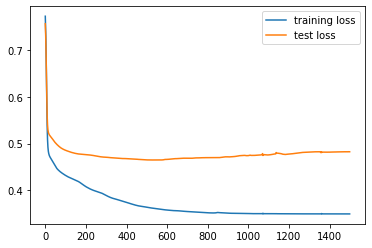

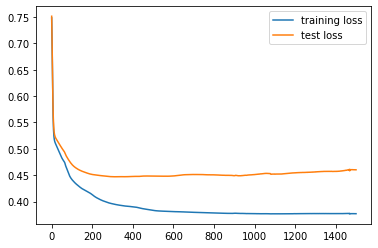

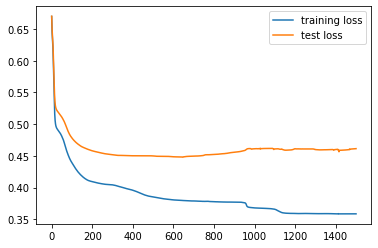

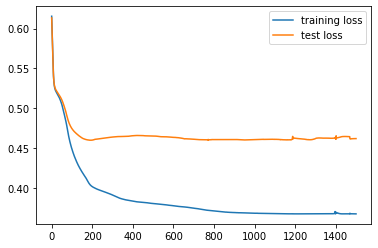

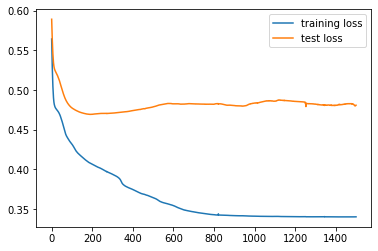

In [20]:
# Neural Networks
proba_nn = []
AUC_nn = []

ohey = OneHotEncoder()
dfy_nn = pd.DataFrame(ohey.fit_transform(pd.DataFrame(dfy)).toarray())

for i, (train_index, test_index) in enumerate(kf.split(dfX_nn_onehot, dfy_nn[1])):
    X_train, y_train = dfX_nn.iloc[train_index], dfy_nn.iloc[train_index]
    X_test, y_test = dfX_nn.iloc[test_index], dfy_nn.iloc[test_index]
    y_train_df = dfy_nn.iloc[train_index]

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # PCA for dimensionality reduction
    principal=PCA(n_components=20)
    principal.fit(X_train)
    X_trainPCA = principal.transform(X_train)
    X_testPCA = principal.transform(X_test)
    """
    # Normalization
    scaler = StandardScaler()
    scaler.fit(X_trainPCA)
    X_trainPCA = scaler.transform(X_trainPCA)
    X_testPCA = scaler.transform(X_testPCA)
    """
    # Converting datasets into pytorch compatible data type
    X_train = torch.FloatTensor(X_trainPCA)
    X_test = torch.FloatTensor(X_testPCA)
    y_train = torch.FloatTensor(y_train.values)
    y_test = torch.FloatTensor(y_test.values)

    # Run only 1 code block: Either the oversample or non-oversampling
    """
    # Oversampling
    weightlist = [1/sum(y_train_df[0]), 1/sum(y_train_df[1])]
    samp = WeightedRandomSampler(weights=[weightlist[cat.argmax()] for cat in y_train], num_samples=len(y_train), replacement=True)

    train = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train, batch_size=128, sampler=samp)
    test = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test, batch_size=128)
    """
    # No oversampling
    train = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train, batch_size=128)
    test = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test, batch_size=128)
    """
    # Check class distributions to ensure oversampling works
    from collections import defaultdict
    store = defaultdict(int)
    for x, y in train_loader:
        for val in y:
            store[int(val.argmax(0))] += 1
        break
    print("== Class distributions in 1 batch ==")
    for key in store:
        print(key, store[key])
    print("==========")
    """
    # Neural network architecture
    class ANN(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(in_features=20, out_features=32)
            self.fc2 = nn.Linear(in_features=32, out_features=32)
            self.fc3 = nn.Linear(in_features=32, out_features=8)
            self.output = nn.Linear(in_features=8, out_features=2)
            self.output2 = nn.Softmax(dim=1)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc3(x))
            x = self.output(x)
            x = self.output2(x)
            return x

    model = ANN()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    # Training
    epochs = 1500
    lossarr = []
    num_batches = len(test_loader)
    testloss = []
    for i in range(epochs):
        model.train()
        for batch, (x, y) in enumerate(train_loader):
            y_hat = model.forward(x)
            loss = criterion(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        lossarr.append(loss.item())

        model.eval()
        test_loss, correct = 0, 0
        preds = []
        with torch.no_grad():
            for X, y in test_loader:
                pred = model(X)
                preds.extend(pred)
                test_loss += criterion(pred, y).item()
                correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
        testloss.append(test_loss/num_batches)

    plt.plot(list(range(epochs)), lossarr, label="training loss")
    plt.plot(list(range(epochs)), testloss, label="test loss")
    plt.legend()
    plt.show()

    model.eval()
    proba = []
    with torch.no_grad():
        for X, y in test_loader:
            pred = model(X)
            proba.extend([p[1] for p in pred])

    y_true = [i[1] for i in y_test]
    preds = [1 if i > 0.5 else 0 for i in proba]
    proba_nn.append(proba)
    AUC_nn.append(roc_auc_score(y_true, proba))

#### Catboost & LightGBM ensemble

In [21]:
proba_cat_lgbm = []
AUC_cat_lgbm = []

# Separately define 2 parameter space and 2 objective functions
cat_param_space = [Real(0.01, 0.3, name='learning_rate'), 
                   Integer(3, 10, name='max_depth'), 
                   Integer(1000, 2000, name='n_estimators'),
                   Real(0.5, 1.0, name='colsample_bylevel'), # also called rsm, how many features should be used each time
                   Real(0.0, 100, name='bagging_temperature'), 
                   Real(0.0, 10, name='random_strength'), 
    #              The scores have no randomness. A normally distributed random variable is added to the score of the feature. 
    #              It has a zero mean and a variance that decreases during the training, 
    #              the value of this parameter is the multiplier of the variance.
                   Real(1.0, 5, name='reg_lambda')]

LGBM = LGBMClassifier(objective='binary', is_unbalance=True)

lgbm_param_space = [Real(0.01, 0.3, name='learning_rate'),
                    Real(0.05, 1, name='colsample_bytree'),
                    Integer(100, 400, name='n_estimators'),
                    Integer(3, 12, name='max_depth'),
                    Real(0.1, 0.4, name='subsample'),
                    Integer(50, 400, name='max_bin'),
                    Integer(31, 100, name='num_leaves'),
                    Categorical([-1], name='verbose')
                ]

@use_named_args(cat_param_space)
def cb_objective(**params):
    cb.set_params(**params)
    return 1 - np.mean(cross_val_score(cb, X_train, y_train, cv=kf, n_jobs=-1,
                                    scoring="roc_auc"))

@use_named_args(lgbm_param_space)
def lgbm_objective(**params):
    LGBM.set_params(**params)

    return 1 - np.mean(cross_val_score(LGBM, X_train, y_train, cv=kf, n_jobs=-1,
                                    scoring="roc_auc"))
    
# Separately decide the best parameters for CatBoost and LightGBM and
# do a arithmetic mean on their predicted probabilities
# Since the datasets for CatBoost and LightGBM without preprocessing are the same,
# only one loop on the CatBoost dataset is needed
for i, (train_index, test_index) in enumerate(kf.split(dfX_cat, dfy)):
    cb = CatBoostClassifier(loss_function='CrossEntropy',
                        random_seed=0, 
                        silent=True
                        )
    X_train, y_train = dfX_cat.iloc[train_index], dfy.iloc[train_index]
    X_test, y_test = dfX_cat.iloc[test_index], dfy.iloc[test_index]

    cb_opt = gp_minimize(cb_objective, 
                      cat_param_space, 
                      n_calls=10, 
                      n_initial_points=3, 
                      random_state=0)

    best_values = cb_opt.x
    optimal_values = dict(zip([param.name for param in cat_param_space], best_values))

    print('optimal_parameters: {}'.format(optimal_values))
    print('updating model with optimal values')
    cb.set_params(**optimal_values)
    cb.fit(X_train, y_train)
    
    lgbm_opt = gp_minimize(lgbm_objective, 
                               lgbm_param_space, 
                               n_calls=10, 
                               n_initial_points=3, 
                               random_state=0)
    
    best_values = lgbm_opt.x
    optimal_values = dict(zip([param.name for param in lgbm_param_space], best_values))

    print('optimal_parameters: {}'.format(optimal_values))
    print('updating model with optimal values')
    LGBM.set_params(**optimal_values)
    LGBM.fit(X_train, y_train)
    proba = LGBM.predict_proba(X_test)
    ensemble_proba = np.mean([cb.predict_proba(X_test)[:, 1], LGBM.predict_proba(X_test)[:, 1]], axis=0)
    proba_cat_lgbm.append(ensemble_proba)
    AUC = roc_auc_score(y_test, ensemble_proba)
    AUC_cat_lgbm.append(AUC)
    print("AUC:", round(AUC, 5))

optimal_parameters: {'learning_rate': 0.09508485957113293, 'max_depth': 8, 'n_estimators': 2000, 'colsample_bylevel': 0.5499546819029231, 'bagging_temperature': 29.118183336019793, 'random_strength': 4.712289662836572, 'reg_lambda': 2.2856392337925353}
updating model with optimal values
optimal_parameters: {'learning_rate': 0.17753487422698905, 'colsample_bytree': 0.6251864355809444, 'n_estimators': 398, 'max_depth': 9, 'subsample': 0.2807632717648445, 'max_bin': 133, 'num_leaves': 31, 'verbose': -1}
updating model with optimal values
AUC: 0.96118
optimal_parameters: {'learning_rate': 0.292629456677111, 'max_depth': 5, 'n_estimators': 1245, 'colsample_bylevel': 0.5646649595965636, 'bagging_temperature': 9.754644888244782, 'random_strength': 0.0, 'reg_lambda': 2.695284885964761}
updating model with optimal values
optimal_parameters: {'learning_rate': 0.16459776234399423, 'colsample_bytree': 0.7115368051099805, 'n_estimators': 352, 'max_depth': 10, 'subsample': 0.22902317124868835, 'max_

### Best model: Catboost & LightGBM ensemble + SMOTE

In [22]:
# Catboost & LightGBM ensemble
proba_cat_lgbm_smote = []
AUC_cat_lgbm_smote = []

cat_param_space = [Real(0.01, 0.3, name='learning_rate'), 
                   Integer(3, 10, name='max_depth'), 
                   Integer(1000, 2000, name='n_estimators'),
                   Real(0.5, 1.0, name='colsample_bylevel'), # also called rsm, how many features should be used each time
                   Real(0.0, 100, name='bagging_temperature'), 
                   Real(0.0, 10, name='random_strength'), 
    #              The scores have no randomness. A normally distributed random variable is added to the score of the feature. 
    #              It has a zero mean and a variance that decreases during the training, 
    #              the value of this parameter is the multiplier of the variance.
                   Real(1.0, 5, name='reg_lambda')]

LGBM = LGBMClassifier(objective='binary', is_unbalance=True)

lgbm_param_space = [Real(0.01, 0.3, name='learning_rate'),
                    Real(0.05, 1, name='colsample_bytree'),
                    Integer(100, 400, name='n_estimators'),
                    Integer(3, 12, name='max_depth'),
                    Real(0.1, 0.4, name='subsample'),
                    Integer(50, 400, name='max_bin'),
                    Integer(31, 100, name='num_leaves'),
                    Categorical([-1], name='verbose')
                ]

@use_named_args(cat_param_space)
def cb_objective(**params):
    cb.set_params(**params)

    return 1 - np.mean(cross_val_score(cb, X_train, y_train, cv=kf, n_jobs=-1,
                                    scoring="roc_auc"))

@use_named_args(lgbm_param_space)
def lgbm_objective(**params):
    LGBM.set_params(**params)
    AOC_ensemble = []
    # also do preprocessing after the train-validation split here
    for i, (train_index, validation_index) in enumerate(kf.split(X_train, y_train)):
        XX_train, yy_train = X_train.iloc[train_index], y_train.iloc[train_index]
        X_val, y_val = X_train.iloc[validation_index], y_train.iloc[validation_index]
        
        scaler = StandardScaler()
        scaler.fit(XX_train)
        XX_train = scaler.transform(XX_train)
        X_val = scaler.transform(X_val)
        
        # PCA for dimensionality reduction
        principal=PCA(n_components=20)
        principal.fit(XX_train)
        XX_train = principal.transform(XX_train)
        X_val = principal.transform(X_val)
        
        smote = BorderlineSMOTE(sampling_strategy={0:yy_train.value_counts()[0]*2, 1:yy_train.value_counts()[1]*2}, k_neighbors=3)
        XX_train, yy_train = smote.fit_resample(XX_train, yy_train)
        
        LGBM.fit(XX_train, yy_train)
        proba = LGBM.predict_proba(X_val)[:, 1]
        AOC_ensemble.append(roc_auc_score(y_val, proba))
    return 1 - np.mean(AOC_ensemble)
# Separately optimize and then ensemble
for i, (train_index, test_index) in enumerate(kf.split(dfX_cat, dfy)):
    cb = CatBoostClassifier(loss_function='CrossEntropy',
                        random_seed=0, 
                        silent=True
                        )
    
    X_train, y_train = dfX_cat.iloc[train_index], dfy.iloc[train_index]
    X_test, y_test = dfX_cat.iloc[test_index], dfy.iloc[test_index]

    opt_cb = gp_minimize(cb_objective, 
                         cat_param_space, 
                         n_calls=10, 
                         n_initial_points=3, 
                         random_state=0)

    best_values = opt_cb.x
    optimal_values = dict(zip([param.name for param in cat_param_space], best_values))

    print('optimal_parameters: {}'.format(optimal_values))
    print('updating model with optimal values')
    cb.set_params(**optimal_values)
    cb.fit(X_train, y_train)
    proba_cb_ensemble = cb.predict_proba(X_test)[:, 1]
    

    X_train, y_train = dfX_lgbm_onehot.iloc[train_index], dfy.iloc[train_index]
    X_test, y_test = dfX_lgbm_onehot.iloc[test_index], dfy.iloc[test_index]
    
    opt_lgbm = gp_minimize(lgbm_objective, 
                           lgbm_param_space, 
                           n_calls=10, 
                           n_initial_points=3, 
                           random_state=0)
    
    best_values = opt_lgbm.x
    optimal_values = dict(zip([param.name for param in lgbm_param_space], best_values))

    print('optimal_parameters: {}'.format(optimal_values))
    print('updating model with optimal values')
    LGBM.set_params(**optimal_values)
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # PCA for dimensionality reduction
    principal=PCA(n_components=20)
    principal.fit(X_train)
    X_train = principal.transform(X_train)
    X_test = principal.transform(X_test)
    # Because SMOTE can't deal with NAN, so we could use it in LightGBM
    # Cause CatBoost website doesn't recommend one-hot encoding
    smote = BorderlineSMOTE(sampling_strategy={0:y_train.value_counts()[0]*2, 1:y_train.value_counts()[1]*2}, k_neighbors=3)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
    LGBM.fit(X_train, y_train)
    ensemble_proba = np.mean([proba_cb_ensemble, LGBM.predict_proba(X_test)[:, 1]], axis=0)
    proba_cat_lgbm_smote.append(ensemble_proba)
    AUC = roc_auc_score(y_test, ensemble_proba)
    AUC_cat_lgbm_smote.append(AUC)
    print("AUC:", round(AUC, 5))

optimal_parameters: {'learning_rate': 0.09508485957113293, 'max_depth': 8, 'n_estimators': 2000, 'colsample_bylevel': 0.5499546819029231, 'bagging_temperature': 29.118183336019793, 'random_strength': 4.712289662836572, 'reg_lambda': 2.2856392337925353}
updating model with optimal values
optimal_parameters: {'learning_rate': 0.18192493928525535, 'colsample_bytree': 0.8520524611519666, 'n_estimators': 357, 'max_depth': 11, 'subsample': 0.28706910903579175, 'max_bin': 185, 'num_leaves': 52, 'verbose': -1}
updating model with optimal values
AUC: 0.97176
optimal_parameters: {'learning_rate': 0.292629456677111, 'max_depth': 5, 'n_estimators': 1245, 'colsample_bylevel': 0.5646649595965636, 'bagging_temperature': 9.754644888244782, 'random_strength': 0.0, 'reg_lambda': 2.695284885964761}
updating model with optimal values
optimal_parameters: {'learning_rate': 0.1136946398997577, 'colsample_bytree': 0.8508466529000077, 'n_estimators': 300, 'max_depth': 11, 'subsample': 0.28329325529420935, 'max

## Final Results

In [23]:
print("Average AUC across 5-folds for Random Forests", np.mean(AUC_rf))
print("Average AUC across 5-folds for Deep Neural Network", np.mean(AUC_nn))
print("Average AUC across 5-folds for XGBoost", np.mean(AUC_xgb))
print("Average AUC across 5-folds for CatBoost", np.mean(AUC_cat))
print("Average AUC across 5-folds for LightGBM", np.mean(AUC_lgbm))
print("Average AUC across 5-folds for Catboost/LightGBM ensemble", np.mean(AUC_cat_lgbm))
print("Average AUC across 5-folds for Catboost/LightGBM ensemble", np.mean(AUC_cat_lgbm_smote))

Average AUC across 5-folds for Random Forests 0.8854079545454546
Average AUC across 5-folds for Deep Neural Network 0.8546380681818183
Average AUC across 5-folds for XGBoost 0.9515840909090908
Average AUC across 5-folds for CatBoost 0.9634761363636363
Average AUC across 5-folds for LightGBM 0.9540477272727272
Average AUC across 5-folds for Catboost/LightGBM ensemble 0.9642159090909092
Average AUC across 5-folds for Catboost/LightGBM ensemble 0.9702977272727272


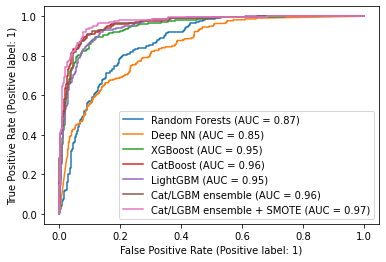

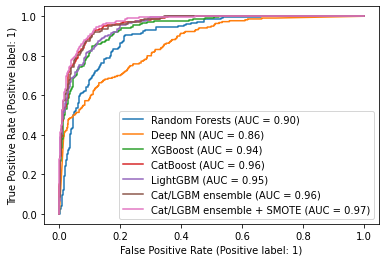

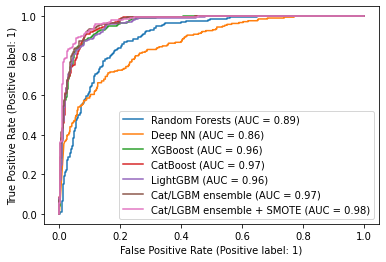

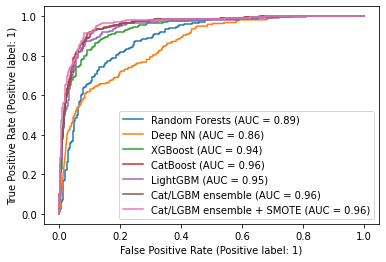

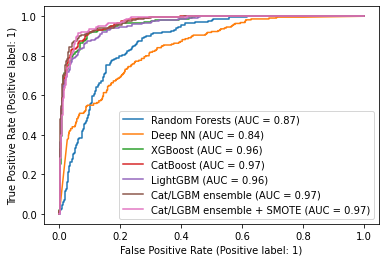

In [24]:
for i, (train_index, test_index) in enumerate(kf.split(dfX_cat, dfy)):
    y_test = dfy.iloc[test_index]
    disp = RocCurveDisplay.from_predictions(y_test, proba_rf[i], name="Random Forests")
    RocCurveDisplay.from_predictions(y_test, proba_nn[i], ax=disp.ax_, name="Deep NN")
    RocCurveDisplay.from_predictions(y_test, proba_xgb[i], ax=disp.ax_, name="XGBoost")
    RocCurveDisplay.from_predictions(y_test, proba_cat[i], ax=disp.ax_, name="CatBoost")
    RocCurveDisplay.from_predictions(y_test, proba_lgbm[i], ax=disp.ax_, name="LightGBM")
    RocCurveDisplay.from_predictions(y_test, proba_cat_lgbm[i], ax=disp.ax_, name="Cat/LGBM ensemble")
    RocCurveDisplay.from_predictions(y_test, proba_cat_lgbm_smote[i], ax=disp.ax_, name="Cat/LGBM ensemble + SMOTE")